In [6]:
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import sys

sys.path.insert(1, '../../modules')
# import modules
from Rouss import *
from Rouss3D import *
from ZoneBudget_ludo import *

In [22]:
sim_name = "pest_3D_R"
org = "org_model"
ws = "workspace"
ref_dr = "200models_ref"

if ws not in os.listdir():
    shutil.copytree(org,ws)
if ref_dr not in os.listdir():
    os.makedirs(ref_dr)
sim = fp.mf6.MFSimulation.load(sim_name,sim_ws=ws)
sim.exe_name = "../../exe/mf6.exe"

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package wel...
    loading package rch...
    loading package rch...
    loading package rch...
    loading package wel...
    loading package chd...
    loading package chd...
    loading package drn...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package obs...
  loading ims package pest_3d_r...


In [23]:
m = sim.get_model()
grid = m.modelgrid
idomain = m.dis.idomain.array
m.remove_package("npf")
m.remove_package("irr")

In [10]:
# load parameters
kQ = np.load("data_200models/kQ.npy")
kPc = np.load("data_200models/kPc.npy")
kep = np.load("data_200models/kep.npy")
kpms = np.load("data_200models/kpms.npy")
kqm = np.load("data_200models/kqm.npy")
irr = np.load("data_200models/irr.npy")
r_cond = np.load("data_200models/cond_riv.npy")


In [66]:
i_rch=2050
coeff_rch = 1


In [82]:
m.sea.stress_period_data.array[0].head

array([0.1   , 0.1   , 0.8875, ..., 0.1   , 0.1   , 0.1   ])

In [89]:
elev_mar = 0
-5+(elev_mar+5)*1.025

0.125

In [70]:
def pred(elev_mar=0,coeff_p=1,i_rch="today",coeff_rch=1,n_models=200,directory="ws"):
    
    # recharge
    m.remove_package("rch")
    
    rch_path="../../data/recharge/recharge_p.tif" # path to rch
    rch_path_2050 = "../../data/changements_clim/rast_rch_2050.tif"
    rch_path_2080 = "../../data/changements_clim/rast_rch_2080.tif"

    ## select recharge (0 : today, 1 : 2050, 2 : 2080)
    if i_rch == 2050:
        rch_path = rch_path_2050
    elif i_rch == 2080:
        rch_path = rch_path_2080
    elif i_rch == "today":
        pass
    else:
        raise Exception("Choose between 2050, 2080 or today")

    rch = rspl_rast(rch_path,grid) # resample to grid
    rch[rch<0]=np.mean(rch[rch>0]) # replace negative values by a mean

    rch[np.abs(idomain).sum(0)==0]=0 # remove some rch
    rch[idomain[0]==1]=0 # remove some rch
    for cell in m.eta.stress_period_data.array[0].cellid:
        rch[cell[1],cell[2]]=0

    rch = liss_mob(rch,5)

    # make a list for rch package
    rch_lst=[]
    for icell in up_act_cell(idomain):
        irow = icell[1]
        icol = icell[2]
        if rch[irow,icol] > 0:
            rch_lst.append(((icell),coeff_rch*rch[irow,icol]/1000/365/86400)) ## apply recharge coeff
    
    rch = fp.mf6.ModflowGwfrch(gwf,pname = "rch",maxbound=len(rch_lst),stress_period_data=rch_lst,save_flows=True)
    rch.write()
 
    ## prélèvements
    m.wel.stress_period_data.array[0].q *= coeff_p
    m.wel.write()
    
    ## elev_mar
    new_fhead = -5+(elev_mar+5)*1.025
    
    for i_model in range(n_models):
        
        ## update npf, irr and rivers ##
            #update npf
            
        m.remove_package("npf")
        m.remove_package("irr")
        
        k = []
        k.append(kqm[i_model,0,0])
        k.append(kQ[i_model])
        k.append(kep[i_model,0,0])
        k.append(kPc[i_model])
        k.append(kpms[i_model,0,0])
        npf = fp.mf6.ModflowGwfnpf(m,pname="npf",k=k)
        npf.write()

        #update irr
        irrig = fp.mf6.ModflowGwfrcha(m,pname="irr",filename="irr.rch",irch=2,recharge=irr[i_model],save_flows=True)
        irrig.write()

        #update rivers
        for i in range(len(m.riv)):
            m.riv[i].stress_period_data.array[0].cond = r_cond[0,i]
            m.riv[i].write()


        sim.run_simulation(silent=True)
        shutil.copyfile(os.path.join(ws,sim_name+".hds"),os.path.join(ref_dr,sim_name+"_{}.hds".format(i_model)))
        shutil.copyfile(os.path.join(ws,sim_name+".cbc"),os.path.join(ref_dr,sim_name+"_{}.cbc".format(i_model)))

SyntaxError: non-default argument follows default argument (<ipython-input-70-02ca59d718fd>, line 1)

In [15]:
for i_model in range(200):

    #update npf
    k = []
    k.append(kqm[i_model,0,0])
    k.append(kQ[i_model])
    k.append(kep[i_model,0,0])
    k.append(kPc[i_model])
    k.append(kpms[i_model,0,0])
    npf = fp.mf6.ModflowGwfnpf(m,pname="npf",k=k)
    npf.write()

    #update irr
    irrig = fp.mf6.ModflowGwfrcha(m,pname="irr",filename="irr.rch",irch=2,recharge=irr[i_model],save_flows=True)
    irrig.write()

    #update rivers
    for i in range(len(m.riv)):
        m.riv[i].stress_period_data.array[0].cond = r_cond[0,i]
        m.riv[i].write()


    sim.run_simulation(silent=True)
    shutil.copyfile(os.path.join(ws,sim_name+".hds"),os.path.join(ref_dr,sim_name+"_{}.hds".format(i_model)))
    shutil.copyfile(os.path.join(ws,sim_name+".cbc"),os.path.join(ref_dr,sim_name+"_{}.cbc".format(i_model)))

In [14]:
pred1_dr = "200models_s1"
pred2_dr = "200models_s2"
pred3_dr = "200models_s3"

for dr in [pred1_dr,pred2_dr,pred3_dr]:
    if dr not in os.listdir():
        os.makedirs(dr)

'200models_ref\\pest_3D_R_0.cbc'

In [98]:
h = get_heads(sim_name,ws)
b = get_cbc(sim_name,ws)

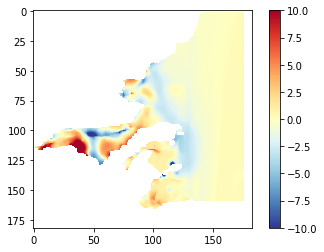

In [99]:
h[h > 1300] = np.nan
plt.imshow(h[1]-h[3],vmax=10,vmin=-10,cmap="RdYlBu_r")
plt.colorbar()